# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [4]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [5]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [6]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [10]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [11]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [12]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [13]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [14]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

/content/trainer.py:243: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
W0813 11:16:59.710000 1828 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/py

Época 1 - pérdida de entrenamiento: 2.1185


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.12613: 100%|██████████| 1246/1246 [00:09<00:00, 130.67it/s]
/content/trainer.py:243: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Época 1 - pérdida de validación: 2.0626


loss 2.08276: 100%|██████████| 11246/11246 [03:05<00:00, 60.58it/s]


Época 2 - pérdida de entrenamiento: 2.0980


val_loss 2.12612: 100%|██████████| 1246/1246 [00:08<00:00, 142.52it/s]

Época 2 - pérdida de validación: 2.0626
Entrenamiento completo.


### Prueba rápida

In [15]:
generate("To be", max_new_tokens=100,use_cache=True)

'To beetits wortorced prissteicur ws: oudias be cad yoe pusu the coim!--sy,\n\nFitizen dit wathald erts.\n\nA:'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [16]:
import torch.nn.functional as F
from typing import Optional

@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    strategy: str = "sampling"  # 'greedy' o 'sampling'
):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Preparamos la entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Salida del modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        # Si devuelve logits + caché
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Extraemos los logits del último token
        logits = logits[:, -1, :]

        # Greedy decoding (elige el token más probable sin muestreo)
        if strategy == "greedy":
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        # Sampling (con temperatura, top-k, top-p)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # Top-k sampling
            if top_k is not None:
                topk_vals, topk_idx = torch.topk(probs, top_k)
                probs = torch.zeros_like(probs).scatter(1, topk_idx, topk_vals)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Top-p (nucleus) sampling
            if top_p is not None:
                sorted_probs, sorted_idx = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                # Máscara: mantener tokens hasta que la suma acumulada > top_p
                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = 0
                sorted_probs[mask] = 0.0

                # Reconstruimos probs con solo los tokens dentro del núcleo
                probs = torch.zeros_like(probs).scatter(1, sorted_idx, sorted_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Finalmente muestreamos
            next_token = torch.multinomial(probs, num_samples=1)

        # Concatenamos el nuevo token
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [17]:
generate("To be", max_new_tokens=100,use_cache=True)

'To beate she lave oto hate, and curod vund Consi,\nOy brarn.\n\nLe thaveice.\n\nhous hoffristinges thall watd,'

In [18]:
#greedy
generateV2("To be",max_new_tokens=100,strategy="greedy")

'To beand the the the the the the the the the the the the the the the the the the the the the the the the '

In [19]:
#temperatura 0.7
generateV2("To be",max_new_tokens=100,temperature=0.7)

'To beeve then to the,\nMare an bere thar ould oy ise theachd walll batill.\n\nCINIUS:\nThes, ak an to mave an'

In [20]:
#temperatura 1.4
generateV2("To be",max_new_tokens=100,temperature=1.4)

'To beis tzor: Aed blat-ode, hen-lemok fow\nYol to fl inn\nA I: cund\nSe bell les can seheta! Meqm Cok,\nEribi'

In [21]:
#top k
generateV2("To be",max_new_tokens=100,top_k=10)

'To bes shend thees fan butrer,\nTans, turs how be meald illl tol.\n\nFiere, wins out waricort on thin th\nBRe'

In [22]:
#top p
generateV2("To be",max_new_tokens=100,top_p=10)

'To bete sonenoceso to woshameat in ar thoow\nNENIUTIUS:\nWhet than ir mas tom: sut ithe mat rome,\nIf ward v'

**Comparación y conclusiones:**

1. Muestreo aleatorio puro (generate)

Selecciona el siguiente token directamente de la distribución de probabilidades completa (softmax), sin restricciones adicionales.

Produce salidas muy variables entre ejecuciones, incluso con el mismo prompt.

Genera alta diversidad, pero con una fuerte tendencia a la incoherencia, especialmente en secuencias largas.

Con el tokenizador por caracteres, las secuencias pierden sentido lingüístico rápidamente, ya que no hay control sobre la estructura de palabras.

2. Greedy (generateV2)

Siempre elige el token con mayor probabilidad en cada paso.

Totalmente determinista: el mismo prompt produce siempre la misma salida.

Tiende a mantener cierta coherencia local, pero fácilmente cae en repeticiones y falta de creatividad.

Con tokenización por caracteres, se observan patrones repetitivos de letras o sílabas.

3. Muestreo con temperatura (generateV2)

Escala las probabilidades antes del muestreo:

temperature < 1 → más conservador

temperature > 1 → más aleatorio y creativo.

Permite ajustar el balance entre coherencia y diversidad.

Con tokenización por caracteres, temperaturas altas generan cadenas de letras sin significado, mientras que temperaturas bajas producen repeticiones más ordenadas.

4. Top-k sampling (generateV2)

Limita la elección al conjunto de k tokens más probables.

Reduce la posibilidad de elegir caracteres muy improbables, lo que en teoría mejora la coherencia.

Con tokenización por caracteres, evita letras raras o poco frecuentes, pero no garantiza palabras completas con sentido.

5. Top-p sampling (generateV2)

Selecciona tokens de un subconjunto cuya probabilidad acumulada sea ≤ p.

Se adapta dinámicamente: en contextos con alta certeza es más determinista , y en contextos ambiguos explora más.

Con tokenización por caracteres, logra un balance razonable entre variabilidad y estabilidad, aunque la coherencia global sigue limitada por el tipo de tokenización.

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [23]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return None


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [24]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:


        return None

In [25]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List



class Expert(nn.Module):
    """
    Una instancia de experto MLP dentro de un MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Inicia el MLP experto dadas las dimensiones/dimensiones ocultas.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x) -> torch.Tensor:
        # El experto simplemente procesa el tensor de entrada
        return self.net(x)

# ---

class Gate(nn.Module):
    """
    Red de 'gating' del MoE.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        # Proyección lineal que mapea el embedding a los logits de los expertos
        self.proj = nn.Linear(config.n_embd, config.moe_args.num_experts)

    def forward(self, x):
        return self.proj(x)

# ---

class MoELayer(nn.Module):
    """
    Capa de Mixture of Experts (MoE) FeedForward
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # La entrada es de forma (batch_size, seq_len, n_embd)
        batch_size, seq_len, n_embd = x.shape

        # Aplanar para procesar cada token de manera independiente
        x_flat = x.view(-1, n_embd)

        # Obtener los logits de la 'gate'
        gate_logits = self.gate(x_flat)  # Forma: (batch_size * seq_len, num_experts)

        # Aplicar softmax para obtener las probabilidades
        gate_probs = F.softmax(gate_logits, dim=-1)

        # Seleccionar los top-k expertos
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.args.top_k, dim=-1)

        # Normalizar las probabilidades de los top-k expertos para que sumen 1
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)

        # Crear un tensor de salida para almacenar los resultados
        output = torch.zeros_like(x_flat)

        # Iterar sobre los tokens para enrutar a los expertos seleccionados
        for i in range(batch_size * seq_len):
            token = x_flat[i]
            token_output = torch.zeros_like(token)

            # Procesar el token con cada uno de los expertos seleccionados
            for k in range(self.args.top_k):
                expert_index = top_k_indices[i, k]
                expert_prob = top_k_probs[i, k]

                # Calcular el resultado del experto y ponderarlo por su probabilidad
                expert_output = self.experts[expert_index](token)
                token_output += expert_prob * expert_output

            output[i] = token_output

        # Devolver el tensor de salida a su forma original
        return output.view(batch_size, seq_len, n_embd)

# ---

class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

In [27]:
# moe con 4 expertos disponibles y 2 por token
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=2)

# Entrenamiento de TinyGPT‑MoE

In [28]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [29]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [30]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 1.91600: 100%|██████████| 11246/11246 [03:13<00:00, 58.15it/s]


Época 1 - pérdida de entrenamiento: 1.9209


val_loss 1.82937: 100%|██████████| 1246/1246 [00:09<00:00, 131.68it/s]


Época 1 - pérdida de validación: 1.8746


loss 1.97901: 100%|██████████| 11246/11246 [03:14<00:00, 57.73it/s]


Época 2 - pérdida de entrenamiento: 2.0027


val_loss 1.82937: 100%|██████████| 1246/1246 [00:08<00:00, 141.98it/s]

Época 2 - pérdida de validación: 1.8746
Entrenamiento completo.


In [36]:
import torch.nn.functional as F
from typing import Optional

@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    strategy: str = "sampling"  # 'greedy' o 'sampling'
):
    model_moe.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        # Preparamos la entrada condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # Salida del modelo
        out = model_moe(idx_cond, kv_cache=kv_cache) if use_cache else model_moe(idx_cond)

        # Si devuelve logits + caché
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # Extraemos los logits del último token
        logits = logits[:, -1, :]

        # Greedy decoding (elige el token más probable sin muestreo)
        if strategy == "greedy":
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        # Sampling (con temperatura, top-k, top-p)
        else:
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            # Top-k sampling
            if top_k is not None:
                topk_vals, topk_idx = torch.topk(probs, top_k)
                probs = torch.zeros_like(probs).scatter(1, topk_idx, topk_vals)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Top-p (nucleus) sampling
            if top_p is not None:
                sorted_probs, sorted_idx = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                # Máscara: mantener tokens hasta que la suma acumulada > top_p
                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = 0
                sorted_probs[mask] = 0.0

                # Reconstruimos probs con solo los tokens dentro del núcleo
                probs = torch.zeros_like(probs).scatter(1, sorted_idx, sorted_probs)
                probs = probs / probs.sum(dim=-1, keepdim=True)

            # Finalmente muestreamos
            next_token = torch.multinomial(probs, num_samples=1)

        # Concatenamos el nuevo token
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

In [37]:
#greedy
generateV2("To be",max_new_tokens=100,strategy="greedy")

'To be the the shat the shat the seare the seart the seartion the the se the seare the seart the seartion '

**Conclusión:**

Predicción del modelo TinyGPT y decodificación greedy:

To beand the the the the the the the the the the the the the the the the the the the the the the the the

Predicción del modelo Moe y decodificación greedy:

To be the the shat the shat the seare the seart the seartion the the se the seare the seart the seartion


Con decodificación greedy, el TinyGPT tiende a repetir de forma monótona el mismo patrón, mientras que el MoE introduce mayor diversidad en las secuencias generadas gracias a la activación de expertos distintos. Esto se observa en la aparición de palabras como “shat”, “seare” o “seartion”, que rompen el ciclo repetitivo del modelo TinyGPT. Sin embargo, debido al uso de un tokenizador por caracteres, ambas salidas carecen de coherencia lingüística y sentido semántico, por lo que las diferencias *se* aprecian más en términos de variación de patrones que en calidad textual.

## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [31]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

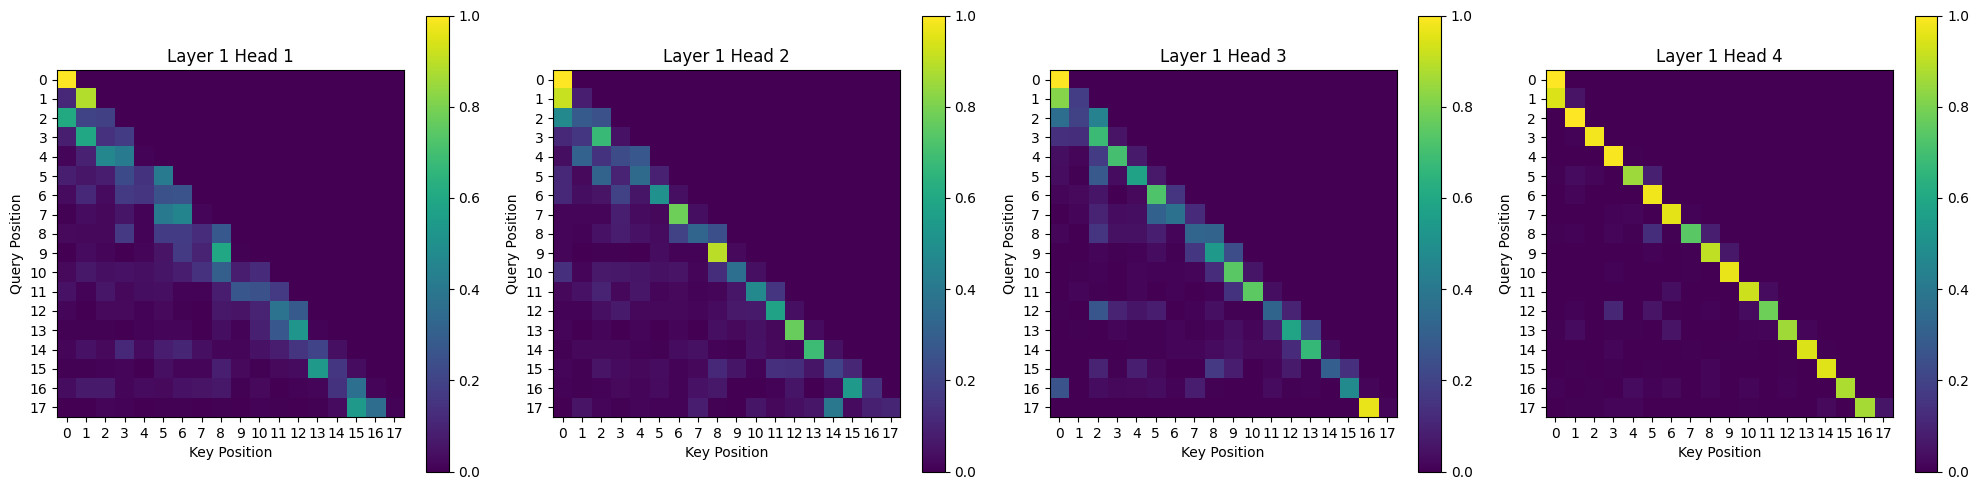

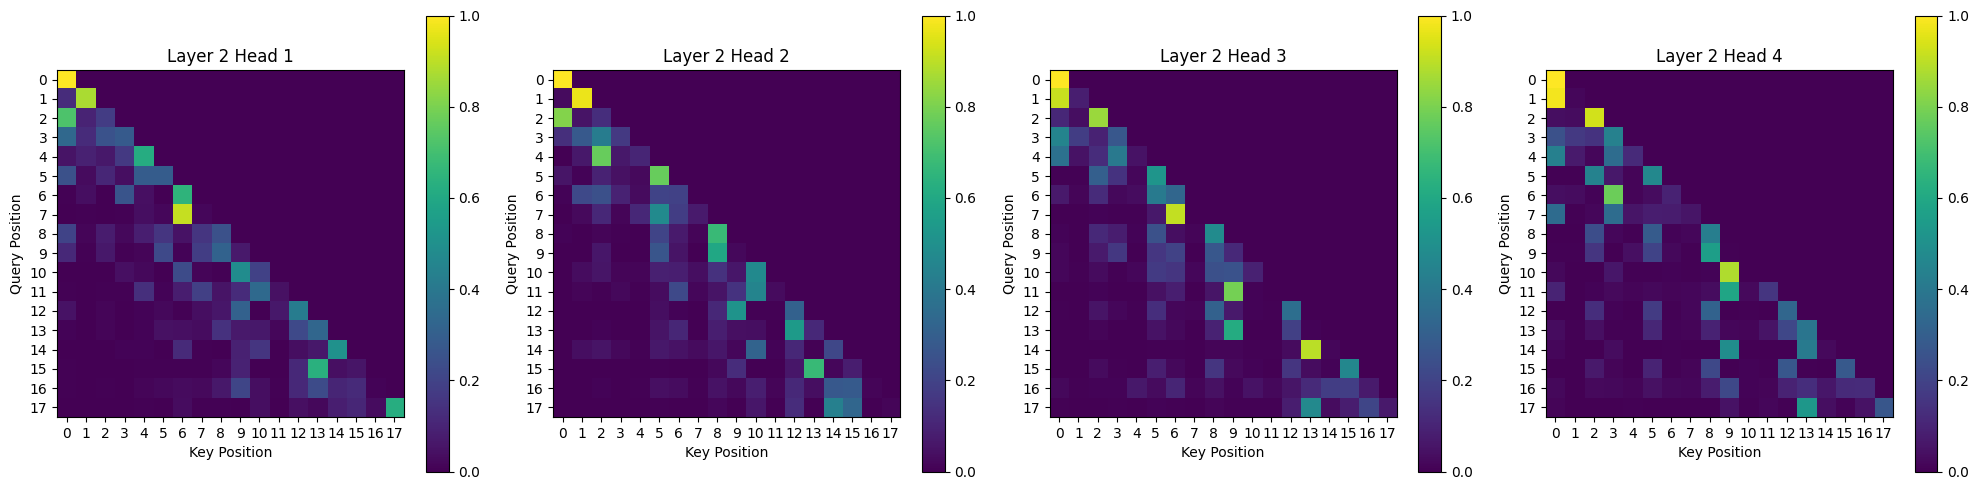

In [34]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

# Conclusiones

El trabajo permitió analizar el comportamiento de diferentes estrategias de decodificación —muestreo aleatorio puro, greedy, muestreo con temperatura, top-k y top-p— aplicadas a un modelo base (TinyGPT) y a una versión mejorada con arquitectura Mixture of Experts (MoE).

Los resultados muestran que:

* Las técnicas de decodificación afectan de manera directa el equilibrio entre diversidad y coherencia de las secuencias generadas. El muestreo aleatorio y temperaturas altas aportan mayor variabilidad, pero sacrifican sentido; greedy y temperaturas bajas generan salidas más predecibles, pero con riesgo de repeticiones; top-k y top-p logran un balance intermedio, aunque no eliminan por completo la incoherencia.

* La tokenización por caracteres impone una limitación importante en la calidad lingüística: ninguna estrategia consigue producir frases gramaticalmente correctas de forma consistente.

* La comparación entre TinyGPT y MoE evidencia que el uso de expertos introduce mayor diversidad en la generación incluso con métodos deterministas como greedy. Mientras TinyGPT tiende a estancarse en patrones repetitivos, el MoE incorpora variaciones que sugieren una explotación diferenciada del conocimiento de cada experto.

* El MoE, aun con las limitaciones de tokenización, muestra un potencial claro para enriquecer las predicciones y evitar ciclos de repetición extrema, lo que podría traducirse en mejoras más notorias con una mejor tokenización.


# ¡Felicitaciones! 🎉

Después de completar las tareas has preentrenado satisfactoriamente para fi... ¡Ahora puedes presumir ante tus amigos sobre cómo funcionan los LLM y los GPT!